In [ ]:
from torch.utils.data import Dataset
import glob
import numpy as np
from PIL import Image

class MaskDataset(Dataset):
  def __init__(self, path, transform = None):
    self.files = glob.glob(path+"/image/*")
    self.masks = glob.glob(path+"/mask/*")
    self.files.sort()
    self.masks.sort()
    self.transform = transform

  def __getitem__(self, i):
    im = Image.open(self.files[i])
    mask = Image.open(self.masks[i]).convert('1') # Load mask in B/W format
    if self.transform:
      im = self.transform(im)
      mask = self.transform(mask)
    return im, mask

  def __len__(self):
    return len(self.files)

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

base_path = "drive/MyDrive/учеба/4 курс/Дипломная работа/segmentation_data/"
img_size = 128

train_dataset = MaskDataset(base_path + 'train', transform =  transforms.Compose([transforms.Resize((img_size,img_size)),  transforms.ToTensor()]) )
train_loader = DataLoader(train_dataset, batch_size = 16,shuffle = True)

val_dataset = MaskDataset(base_path + 'val',transform =  transforms.Compose([transforms.Resize((img_size,img_size)), transforms.ToTensor()]) )
val_loader = DataLoader(val_dataset, batch_size = 1,shuffle =False)


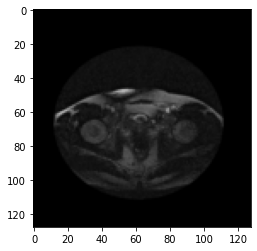

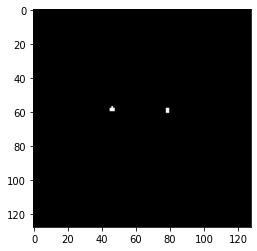

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,2))
%matplotlib inline


def show(batch):
  # create grid of images
  # https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
  img_grid = make_grid(batch)
  plt.figure()
  plt.imshow(np.transpose(img_grid.numpy(), (1,2,0)))
  plt.show()

images, masks = iter(val_loader).next()

show(images)
show(masks)

In [ ]:
import os
import shutil

def reinit_tensorboard(clear_log = True):
  # Directory for log files
  logs_base_dir = "runs"
  if clear_log:
    # Clear logs
    shutil.rmtree(logs_base_dir, ignore_errors = True)
    os.makedirs(logs_base_dir, exist_ok=True)
  # Colab magic
  %load_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

# Code for train

In [ ]:
! pip install segmentation_models_pytorch

     |████████████████████████████████| 71kB 4.8MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 245kB 42.6MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=0eec61e28a45ced8bd0760016cfeb83334758a69d5323d4df85b84cdb847d458
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=62d9b1ec2a4e5d60f8355929de345d76dd03a137df5da7df04f4dfb94b6446cb
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import torch.nn as nn
class FocalLoss(nn.Module):
    def __init__(self, alpha=.8, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
!pip install torchmetrics

     |████████████████████████████████| 276kB 8.0MB/s 


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torchvision
from segmentation_models_pytorch.utils.losses import JaccardLoss
from segmentation_models_pytorch.utils.metrics import IoU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
writer = SummaryWriter(comment = "image_show")
IoU_function = IoU().to(device)


def show_results(model,epoch, auto_model=False):
  '''
    Write obtained masks to tensorboard log
  '''
  for im, gt in val_loader:
    outputs = model(im.to(device))
    if not auto_model:
      IoU_score = IoU_function(outputs, gt.to(device).int())
      print("IoU score {}".format(IoU_score))
    show(gt)
    show(outputs.cpu()) 
    writer.add_image("Images", torchvision.utils.make_grid(im),epoch)
    writer.add_image("Masks", torchvision.utils.make_grid(outputs),epoch)
    writer.flush()
    writer.close()
    return 

def train(model, auto_model=False):
  
  model.train()
  model.to(device)
  

  criterion = FocalLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  best_accuracy = 0
  
  for epoch in range(100):
    correct = 0
    train_loss = 0
    steps = 0
    for img_batch, masks_batch in train_loader:
      optimizer.zero_grad()
      output = model(img_batch.to(device))
      loss = criterion(output, masks_batch.to(device))
      train_loss += loss.cpu().item()
      steps += 1
      loss.backward()
      optimizer.step()
    print("Epoch {} Train loss {}".format(epoch,train_loss))    
    show_results(model,epoch, auto_model)    
writer.close()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.up = nn.Sequential(nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2),
            nn.ReLU()
        )

        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = nn.Sequential(
        nn.Conv2d(64, n_classes, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    )

        # Weight initialization
        for m in self.modules():
          if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            if m.bias is not None:
              m.bias.data.zero_()

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
reinit_tensorboard()
model = UNet(1, 1)
train(model)



In [ ]:
# !kill 300

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
torch.save(model.state_dict(), base_path + 'model/new_modelJacard2')

In [ ]:
for im, gt in val_loader:
    outputs = model(im.to(device))
    IoU_score = IoU_function(outputs, gt.to(device).int())
    s += IoU_score
    n += 1
average_IoU_score = s / n
average_IoU_score

tensor(0.8223, device='cuda:0')

# Upload model

In [ ]:
model = UNet(1, 1)
model.load_state_dict(torch.load(base_path + 'model/model6' , map_location='cpu'))
model.to(device)
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [ ]:
PRETRAINED_IMG_SIZE = 128

transform = transforms.Compose([transforms.Resize((PRETRAINED_IMG_SIZE, PRETRAINED_IMG_SIZE)), transforms.ToTensor()])


In [ ]:
test_img = transform(Image.open(base_path+"val/image/R15_IM000000.png"))
test_img

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
model(test_img)

RuntimeError: ignored

In [ ]:
import random
n = 48
for k, (i, m) in enumerate(val_loader):
  print(k)
  images, masks = i, m
  if k == n:
    break
with torch.no_grad():
  test_mask = model(images)
test_mask

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


tensor([[[[0.0208, 0.0092, 0.0140,  ..., 0.0150, 0.0131, 0.0306],
          [0.0105, 0.0042, 0.0081,  ..., 0.0078, 0.0070, 0.0146],
          [0.0135, 0.0068, 0.0094,  ..., 0.0086, 0.0064, 0.0155],
          ...,
          [0.0169, 0.0080, 0.0122,  ..., 0.0112, 0.0093, 0.0136],
          [0.0122, 0.0055, 0.0096,  ..., 0.0103, 0.0077, 0.0153],
          [0.0291, 0.0094, 0.0145,  ..., 0.0126, 0.0123, 0.0285]]]])

In [ ]:
def tensor_to_image(tensor_img):
  resize_F = transforms.Resize((512,512))
  img = resize_F(tensor_img).cpu().detach().numpy()[0]
  #convert image back to Height,Width,Channels
  img = np.transpose(img, (1,2,0)).squeeze()

  # dim = np.zeros((224,224))
  # img = np.stack((img,dim, dim), axis=2)

  return Image.fromarray((img * 255).astype(np.uint8)).convert("RGBA")

In [ ]:
def make_black_transparent(img, conf=100):
  datas = img.getdata()
  newData = []
  for item in datas:
      if item[0] < conf and item[1] < conf and item[2] < conf:
          newData.append((0, 0, 0, 0))
      elif item[0] > 0 and item[1] > 0 and item[2] > 0:
          newData.append((item[0], 0, 0, 255))
      else:
          newData.append(item)

  img.putdata(newData)
  return img

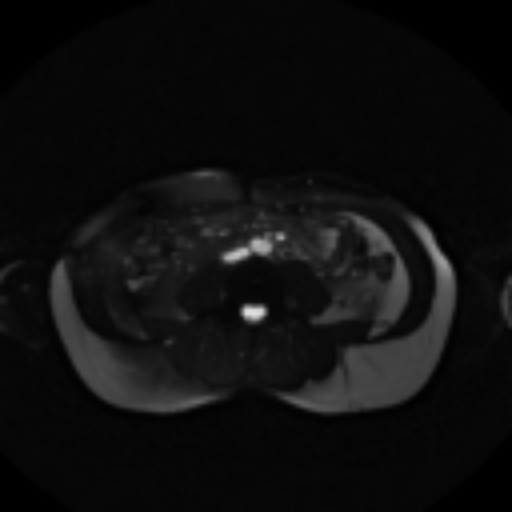

In [ ]:
tensor_to_image(images)

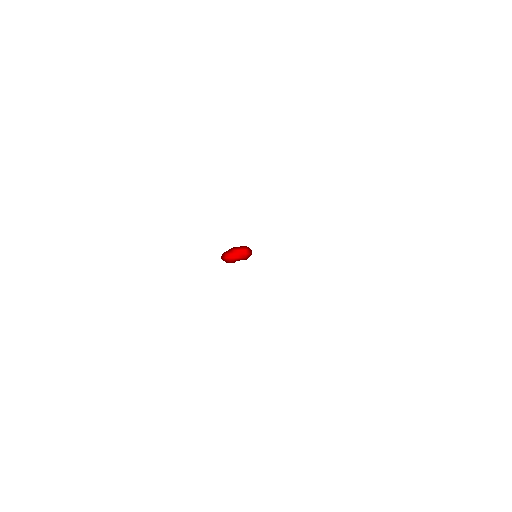

In [ ]:
make_black_transparent(tensor_to_image(test_mask))

In [ ]:
background = tensor_to_image(images)
foreground = make_black_transparent(tensor_to_image(test_mask))

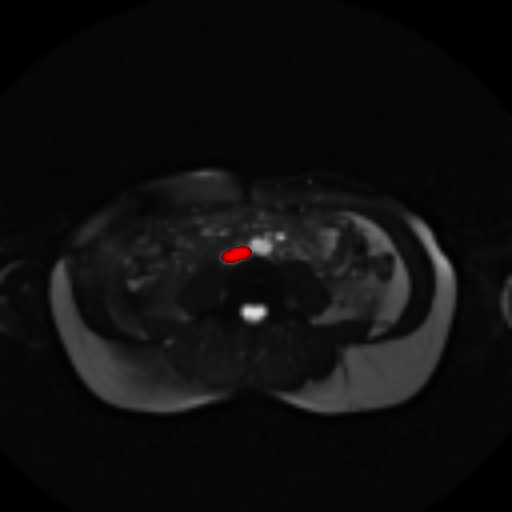

In [ ]:
background.paste(foreground, (0, 0), foreground)
background

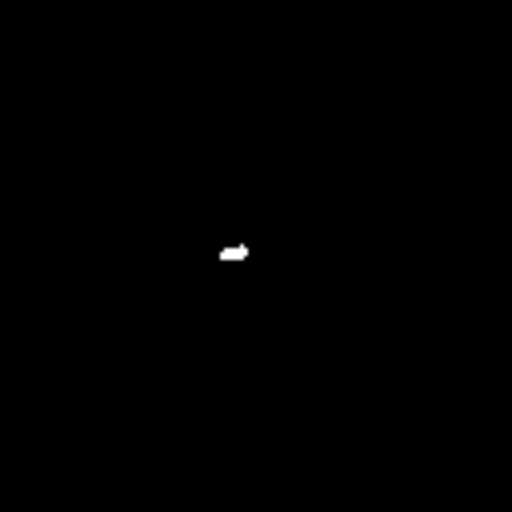

In [ ]:
mask_true = tensor_to_image(masks)
mask_true

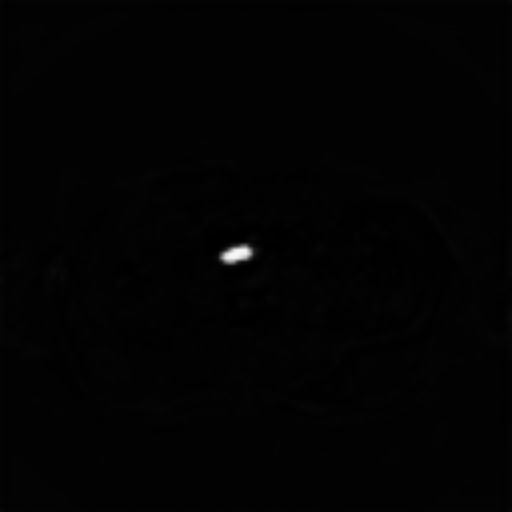

In [ ]:
mask_predict = tensor_to_image(test_mask)
mask_predict

In [ ]:
# ! pip install segmentation_models_pytorch

In [ ]:
import segmentation_models_pytorch as smp

model_auto = smp.Unet(
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [ ]:
reinit_tensorboard()
train(model_auto, True)


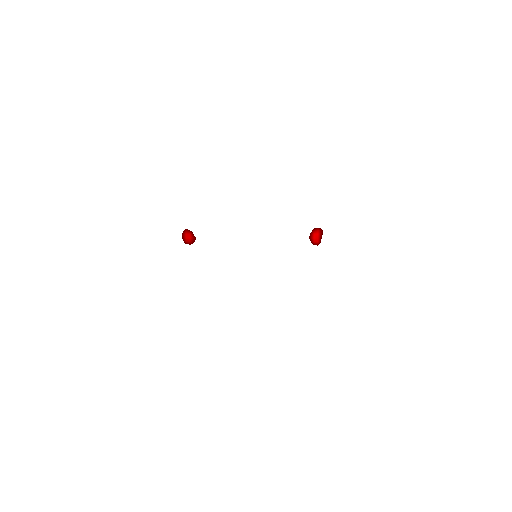

In [ ]:
pil_mask = make_black_transparent(tensor_to_image(test_mask))
pil_mask

In [ ]:
np_mask = np.array(pil_mask)
mask_shape = np_mask.shape
sum(np_mask[0][0])

0

In [ ]:
mass = []
for i in range(1, mask_shape[0] // 2 - 1):
  for j in range(1, mask_shape[1] // 2 - 1):
    if sum(np_mask[i][j]) > 0:
      if sum(np_mask[i - 1][j]) == 0 or sum(np_mask[i][j - 1]) == 0 or sum(np_mask[i][j + 1]) == 0 or sum(np_mask[i + 1][j]) == 0:
        mass.append([i, j])

In [ ]:
n = len(mass)
used = [False] * n
v = 0
INF = 512 * 512
new_arr = []
first = v
av_s = 0
av_k = 0
for i in range(n):
  new_arr.append(mass[v][1])
  new_arr.append(mass[v][0])
  used[v] = True
  to = -1
  min_dist = INF
  for j in range(n):
    if not used[j] and min_dist > abs(mass[v][0] - mass[j][0]) + abs(mass[v][1] - mass[j][1]):
      min_dist = abs(mass[v][0] - mass[j][0]) + abs(mass[v][1] - mass[j][1])
      to = j
  if av_s < av_k * (min_dist + 10):
    new_arr.append(mass[first][1])
    new_arr.append(mass[first][0])
    first = to
    av_s = 0
    av_k = 0
  
  av_s += min_dist
  av_k += 1
  v = to

In [ ]:
'[' + ', '.join(str(m) for m in new_arr) + ']'

'[185, 229, 186, 229, 185, 229, 187, 229, 187, 229, 188, 230, 188, 230, 189, 230, 189, 230, 190, 231, 190, 231, 191, 231, 191, 231, 192, 232, 192, 232, 192, 233, 192, 233, 193, 234, 193, 234, 193, 235, 193, 235, 194, 236, 194, 236, 195, 237, 195, 237, 195, 238, 195, 238, 195, 239, 195, 239, 194, 240, 194, 240, 194, 241, 194, 241, 193, 242, 193, 242, 192, 243, 192, 243, 191, 243, 191, 243, 190, 244, 190, 244, 189, 244, 189, 244, 188, 243, 188, 243, 187, 243, 187, 243, 186, 243, 186, 243, 185, 243, 185, 243, 184, 242, 184, 242, 184, 241, 184, 241, 183, 240, 183, 240, 183, 239, 183, 239, 182, 238, 182, 238, 182, 237, 182, 237, 182, 236, 182, 236, 182, 235, 182, 235, 182, 234, 182, 234, 182, 233, 182, 233, 183, 232, 183, 232, 183, 231, 183, 231, 184, 230, 184, 230]'